In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from load_utils import load_data, clean_data
import itertools

In [2]:
# read table for identifying corresponding items across modules
items = pd.read_excel('ADOS2_items_and_descriptions.xlsx', sheet_name='Übergreifende Items M1-M4', index_col=0)
items.drop(columns=[f'Unnamed: {i}' for i in (3,6,9,12,13,14)], inplace=True)
items.rename(columns={f'Unnamed: {i*3+1}': f'M{i+1}' for i in range(4)}, inplace=True)

# clean up: if anything ends with a space, remove it
def drop_space(x):
    try:
        while x.endswith(' '):
            x = x[:-1]
    except AttributeError:
        pass
    return x

items = items.applymap(drop_space)

# replace similar descriptions that actually belong to a corresponding item
items.mask(items == 'Deskriptive, konventionelle, instrumentelle oder informative Gesten', 'Gestik', inplace=True)
items.mask(items == 'Ungewöhnliche repetitive Interessen oder stereotype Verhaltensweisen', 'Exzessives Interesse an ungewöhnlichen oder sehr spezifischen Themen/ Objekten oder repetitive Verhaltensweisen', inplace=True)
items.mask(items == 'Fantasiespiel/ Kreativität', 'Vorstellungsvermögen/ Kreativität', inplace=True) 
items.mask(items == 'Hyperaktivität/ Unruhe', 'Hyperaktivität', inplace=True)
items.mask(items == 'Sozial gerichteter mimischer Ausdruck', 'An den Untersucher gerichteter mimischer Ausdruck', inplace=True)
items.mask(items == 'Intonation der Lautäußerungen oder sprachlichen Äußerungen', 'Mit Autismus assoziierte abnorme Sprache (Intonation/ Lautstärke/ Rhythmus/ Sprechtempo)', inplace=True)

# remove spaces in the beginning of columns
for c in items.columns:
    if c.startswith(' '):
        items.rename(columns={c: c[1:]}, inplace=True)
items

,M1,ADOS Modul 1,M2,ADOS Modul 2,M3,ADOS Modul 3,M4,ADOS Modul 4
1.0,A1,Gesamtniveau der nicht echolalischen Sprache,A1,Gesamtniveau der nicht echolalischen Sprache,A1,Gesamtniveau der nicht echolalischen Sprache,A1,Gesamtniveau der nicht echolalischen Sprache
2.0,A2,"Häufigkeit von spontanen Lautäußerungen, die a...",A2,Mit Autismus assoziierte abnorme Sprache (Into...,A2,Mit Autismus assoziierte abnorme Sprache (Into...,A2,Mit Autismus assoziierte abnorme Sprache (Into...
3.0,A3,Mit Autismus assoziierte abnorme Sprache (Into...,A3,Unmittelbare Echolalie,A3,Unmittelbare Echolalie,A3,Unmittelbare Echolalie
4.0,A4,Unmittelbare Echolalie,A4,Stereotyper/eigentümlicher Sprachgebrauch,A4,Stereotyper/eigentümlicher Sprachgebrauch,A4,Stereotyper/eigentümlicher Sprachgebrauch
5.0,A5,Stereotyper/eigentümlicher Sprachgebrauch,A5,Konversation,A5,Informationen geben,A5,Informationen geben
6.0,A6,Den Körper einer anderen Person benutzen,A6,Auf etwas deuten,A6,Informationen erfragen,A6,Informationen erfragen
7.0,A7,Auf etwas deuten,A7,Gestik,A7,Berichten über Ereignisse,A7,Berichten über Ereignisse
8.0,A8,Gestik,B1,Ungewöhnlicher Blickkontakt,A8,Konversation,A8,Konversation
9.0,B1,Ungewöhnlicher Blickkontakt,B2,An den Untersucher gerichteter mimischer Ausdruck,A9,Gestik,A9,Gestik
10.0,B2,Reaktives soziales Lächeln,B3,Gemeinsame Freude an der Interaktion,B1,Ungewöhnlicher Blickkontakt,A10,Empathische oder emotionale Gesten


In [3]:
# find unique item descriptions
unique_items = []
for m in [f'ADOS Modul {m}' for m in range(1,5)]:
    unique_items += list(items[m].values)
unique_items, n_occurence = np.unique(np.array(unique_items), return_counts=True)
unique = pd.DataFrame(n_occurence, index=unique_items, columns=['count'])
unique.drop('nan', inplace=True)

In [4]:
# Build new names, based on item descriptions: If items share the same description, they are associated to each other
modules = {i: pd.DataFrame(items[f'M{i}'].values, index=items[f'ADOS Modul {i}']) for i in range(1,5)}
names = []
for item, _ in unique.iterrows():
    name = ''
    for m in range(1, 5):  # check if the item is present for each module
        if item in modules[m].index:  # if yes, append its name in the respective module
            name += modules[m].loc[item].values[0] + '/'
        else:
            name += '-/'  # if not, mark it with '-'
    names.append(name[:-1])  # delete last '/'
unique['name'] = names
unique

,count,name
Allgemeine Beurteilung der Qualität des Rapports,1,-/B12/-/-
An den Untersucher gerichteter mimischer Ausdruck,4,B3/B2/B2/B2
Auf etwas deuten,2,A7/A6/-/-
Ausmaß der sozialen Annäherung/ Aufrechterhalten der Aufmerksamkeit,1,-/-/B8/-
Ausmaß der wechselseitigen sozialen Kommunikation,3,-/B11/B10/B12
Berichten über Ereignisse,2,-/-/A7/A7
Den Körper einer anderen Person benutzen,1,A6/-/-/-
Eigenverantwortlichkeit,1,-/-/-/B8
Einfühlungsvermögen/ Äußerungen über die Gefühle anderer,2,-/-/B5/B6
Empathische oder emotionale Gesten,1,-/-/-/A10


In [5]:
# build renaming dictionary: map original naming conventions to new names
naming_dict = {i: {} for i in range(1,5)}  # one dict for each module

for name in names:
    inames = name.split('/')  # position of the new name encodes the module
    for i, mod in enumerate(naming_dict):
        naming_dict[mod][inames[i]] = name

# remove renaming dictionary-entry of items that are not part of the module
for i in naming_dict:
    del naming_dict[i]['-']

In [6]:
# load actual data, clean up and do some renaming
modules = []
for m in naming_dict:
    df = load_data(m, replace_nan=-5)
    # rename columns ending with space
    for c in df.columns:
        if c.endswith(' '):
            df.rename(columns={c: c[:-1]}, inplace=True)

    df.rename(columns=naming_dict[m], inplace=True)
    modules.append(df)
    
modules = pd.concat(modules, join='outer').fillna(-5)
modules = modules.rename(columns={'F70': 'ID'})
modules = modules.rename(columns={'1_IQ_Gesamt': 'IQ'})

Old N: 113; After deletion of Subjects with n_nan >= 5: 106
Old N: 150; After deletion of Subjects with n_nan >= 5: 140
Old N: 557; After deletion of Subjects with n_nan >= 5: 541
Old N: 305; After deletion of Subjects with n_nan >= 5: 297


In [7]:
# sample characteristics
print('Total: N={}, mean age={}+/-{}'.format(len(modules), modules['age'].mean(), modules['age'].std()))
print('ASD: N={}, non-ASD: N={}'.format(modules['ASD'].sum(), (modules['ASD']==0).sum()))
print('ID: N={}, ID and ASD: N={}, ID and non-ASD: N={}'.format(modules['ID'].sum(), np.sum(np.logical_and(modules['ID'], modules['ASD'])), np.sum(np.logical_and(modules['ID'], modules['ASD']==0)),))

print('==== Table values ====')
N = len(modules)
def print_ratios(mask1, mask2):
    N1 = np.sum(mask1)
    N2 = np.sum(mask2)
    N12 = np.sum(np.logical_and(mask1, mask2))
    if N12 == N1:
        rc = N12/N2 * 100
    else:
        rc = N12/N1 * 100
    print('N: {:d}, %: {:.1f}'.format(N12, rc))

def print_mean_std(mask, column):
    valid = modules[column] > -5
    mask = np.logical_and(mask, valid)
    N = len(modules[mask][column])
    mn = modules[mask][column].mean()
    std = modules[mask][column].std()
    print('N={}, mn/std={:.1f}/{:.1f}'.format(N, mn, std))
    
diag = {'ASD': modules['ASD'] == 1,
    'non ASD': modules['ASD'] == 0,
    'ID': modules['ID'] == 1,
    'non-ID': modules['ID'] == 0}
    
for d, c in itertools.product(diag, ['age', 'IQ', 'IQ Level']):
    print(f'{d} {c}')
    print_mean_std(diag[d], c)

Total: N=1084, mean age=14.001845018450185+/-10.326256608284153
ASD: N=440, non-ASD: N=644
ID: N=60, ID and ASD: N=28, ID and non-ASD: N=32
==== Table values ====
ASD age
N=440, mn/std=14.9/11.1
ASD IQ
N=370, mn/std=101.2/26.0
ASD IQ Level
N=440, mn/std=3.3/1.5
non ASD age
N=644, mn/std=13.4/9.7
non ASD IQ
N=545, mn/std=99.3/21.1
non ASD IQ Level
N=644, mn/std=3.2/1.2
ID age
N=60, mn/std=12.9/8.9
ID IQ
N=23, mn/std=57.3/9.6
ID IQ Level
N=60, mn/std=5.5/0.7
non-ID age
N=1024, mn/std=14.1/10.4
non-ID IQ
N=892, mn/std=101.2/22.4
non-ID IQ Level
N=1024, mn/std=3.1/1.2


In [8]:
# Test chi-squre for ASD/non-ASD and IQ Level:
iql_asd, f_asd = np.unique(modules[modules['ASD']==1]['IQ Level'], return_counts=True)
iql_nasd, f_nasd = np.unique(modules[modules['ASD']==0]['IQ Level'], return_counts=True)
assert np.array_equal(iql_asd, iql_nasd)
assert np.all(f_nasd > 5)  # expect a minimim frequency in each category
assert np.all(f_asd > 5)  # expect a minimim frequency in each category
stats.chi2_contingency(observed=(f_asd, f_nasd))

(84.04171483063104,
 5.213582102776968e-16,
 6,
 array([[ 27.19557196, 113.65313653, 158.30258303,  49.92619926,
          67.78597786,  17.45387454,   5.68265683],
        [ 39.80442804, 166.34686347, 231.69741697,  73.07380074,
          99.21402214,  25.54612546,   8.31734317]]))

Text(0, 0.5, 'P(IQ Level)')

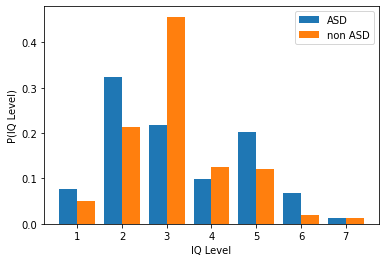

In [9]:
# plot iq level distribution of ASD and non-ASD groups
plt.bar(iql_asd-.2, f_asd/f_asd.sum(), width=.4, label='ASD')
plt.bar(iql_nasd+.2, f_nasd/f_nasd.sum(), width=.4, label='non ASD')
plt.legend()
plt.xlabel('IQ Level')
plt.ylabel('P(IQ Level)')

In [10]:
# build ml data
y = modules['ASD']
x = modules.drop(columns=['ASD', 'IQ']).astype(int)

from sklearn import tree, ensemble, svm, linear_model
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
import graphviz

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, stratify=x['IQ Level'], random_state=1)

In [11]:
# define and execute grid searches for parameter optimization
cv_splitter = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

models = {'dt': tree.DecisionTreeClassifier(random_state=42)}

params = {'dt':  {'max_depth': [2, 3, 4, 5, 7, 10, 15],
                  'ccp_alpha': [0, .1, .5, 1, 5, 10],
                  'criterion': ['gini', 'entropy'],
                  'min_samples_split': [2, 3, 4, 10],
                  'min_samples_leaf': [1, 2, 4, 8, 16],
                  'min_impurity_decrease': [0.0]}}

scoring_metric = 'accuracy'

def grid_search(m):
    print(f' ==== {m} ==== ')
    gs = GridSearchCV(models[m], params[m], scoring=scoring_metric, return_train_score=True, cv=cv_splitter)
    gs.fit(x_train, y_train)
    print('Best CV Mean {}: {}'.format(scoring_metric, gs.best_score_))
    print('Best Params: {}'.format(gs.best_params_))
    return gs
          
gs_tree = grid_search('dt')

 ==== dt ==== 
Best CV Mean accuracy: 0.8073956733230927
Best Params: {'ccp_alpha': 0, 'criterion': 'entropy', 'max_depth': 5, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 8, 'min_samples_split': 2}


In [12]:
# test generalization
tree_train = gs_tree.best_estimator_.fit(x_train, y_train)
tree_train.score(x_test, y_test)

0.8433179723502304

In [13]:
# grid search for parameter optimization for random forest

models['rf'] = ensemble.RandomForestClassifier(**gs_tree.best_params_, random_state=42)
params['rf'] = {'n_estimators': [2, 4, 8, 16, 32, 64, 128, 256], 'max_samples': [.3, .5, .7, .8, None]}

gs_rf = grid_search('rf')

# test generalization
rf_train = gs_rf.best_estimator_.fit(x_train, y_train)
rf_train.score(x_test, y_test)

 ==== rf ==== 
Best CV Mean accuracy: 0.8373442566990954
Best Params: {'max_samples': 0.8, 'n_estimators': 256}


0.8986175115207373

In [14]:
# define sub-cohorts
groups = {'all': lambda m: np.ones(len(m), dtype=bool), 
          'male': lambda m: m['sex'] == 1, 
          'female': lambda m: m['sex'] == 2,
          'average IQL': lambda m: m['IQ Level'] == 3,
          'above average IQL': lambda m: m['IQ Level'] <= 2,
          'below average IQL': lambda m: m['IQ Level'] >= 5,
          'ID': lambda m: m['ID'] == 1}

In [15]:
# Baseline: ADOS/2 cut-off

mod1 = load_data(1, recode=False)  # need to load module 1 with original codings for ADOS/2 cutoff-calculations


def ados2_cutoff(subject):
    """
    Returns the ASD-Diagnosis for a subject subject based on cutoffs as defined in ADOS2
    """
    if subject['Modul'] == 1:
        items = ['A2', 'A7', 'A8', 'B1', 'B3', 'B4', 'B5','B9', 'B10', 'B11', 'B12', 'A3', 'A5', 'D1', 'D2', 'D4']
        if mod1.loc[subject.name]['A1'] == 3:
            co = 11
        else:
            co = 8
        return subject[items].values.sum() >= co
    
    if subject['Modul'] == 2:
        items = ['A6', 'A7', 'B1', 'B2', 'B3', 'B5', 'B6', 'B8', 'B11', 'B12', 'A4', 'D1', 'D2', 'D4']
        if subject['age'] < 5:
            co = 7
        else:
            co = 8
        return subject[items].values.sum() >= co
    
    if subject['Modul'] == 3:
        items = ['A7', 'A8', 'A9', 'B1', 'B2', 'B4', 'B7', 'B8', 'B9', 'B10', 'A4', 'D1', 'D2', 'D4' ]
        co = 8
        return subject[items].values.sum() >= co
    
    if subject['Modul'] == 4:
        comm_items = ['A4', 'A8', 'A9', 'A10']
        sia_items = ['B1', 'B2', 'B6', 'B8', 'B9', 'B11', 'B12']
        
        co_comm = subject[comm_items].values.sum() >= 2
        co_sia = subject[sia_items].values.sum() >=  4
        co_all = subject[comm_items + sia_items].values.sum() >= 7
        
        return co_comm and co_sia and co_all

def predict_ados2_cutoff(x):
    """
    Wrapper for calculating ADOS2 cutoffs over the whole data
    """
    cutoffs = np.zeros(len(x))
    for i, (idx, s) in enumerate(x.mask(x==-5,0).iterrows()): # for ados cutoff, fill NaNs with 0 instead of -5
        # rename items to their specific module's name
        s.index = [name.split('/')[int(s['Modul']-1)] if len(name.split('/')) == 4 else name for name in s.index]
        # get prediction
        cutoffs[i] = ados2_cutoff(s)
        
    return cutoffs
    
def get_results(y, y_p, x):
    """
    Compare individual metrics for the different sub-cohorts
    """
    results = {}
    for k, condition in groups.items():
            p, gt = y_p[condition(x)], y[condition(x)]
            tp = np.logical_and(p == gt, gt)
            fp = np.logical_and(p==1, gt==0)
            fn = np.logical_and(p==0, gt==1)
            results[k] = {'error': 1 - np.sum(p == gt) / len(gt),
                    'fpr': np.sum(fp) / np.sum(gt == 0),
                    'fp/all': np.sum(fp) / len(gt),
                    'fn/all': np.sum(fn) / len(gt),
                    'N': len(gt),
                    'ASD ratio': np.sum(gt) / len(gt)}
    results = pd.DataFrame(results).T
    return results
    
def ados2_cutoff_results(x, y):
    """
    Returns a DataFrame with predicted and real Diagnosis with subcohort-relevant Information 
    as well as a DataFrame with subcohort-specific metrics 
    """
    y_p = predict_ados2_cutoff(x)
    results = get_results(y, y_p, x)
    factors = x[['ID', 'sex', 'IQ Level']]
    factors['ASD_p'] = y_p
    factors['ASD'] = y
    return factors, results

Old N: 113; After deletion of Subjects with n_nan >= 5: 106


In [16]:
def complete_prediction(xt, yt, model):
    """
    Make out of bag predictions for the whole data with supervised ML-Methods:
    - Run a 5-fold CV Split, train on 4, test on the remaining
    - combine test predictions
    """
    y_test_p = []
    y_test = []
    factors = []
    for i, (train_index, test_index) in enumerate(StratifiedKFold(n_splits=5, shuffle=True, random_state=0).split(xt, yt)):
        x_train, y_train = xt.iloc[train_index], yt.iloc[train_index]
        rf = model.fit(x_train, y_train)
        y_test_p.append(rf.predict(xt.iloc[test_index]))
        y_test.append(yt.iloc[test_index])
        factors.append(xt.iloc[test_index][['ID', 'sex', 'IQ Level']])

    y_test_p = np.concatenate(y_test_p)
    y_test = np.concatenate(y_test)

    assert len(y_test) == len(xt)

    factors = pd.DataFrame(np.concatenate(factors), columns=['ID', 'sex', 'IQ Level'])
    factors['ASD'] = y_test
    factors['ASD_p'] = y_test_p

    results = {}
    for k, condition in groups.items():
        p, gt = factors[condition(factors)]['ASD_p'], factors[condition(factors)]['ASD']
        tp = np.logical_and(p == gt, gt)
        fp = np.logical_and(p==1, gt==0)
        fn = np.logical_and(p==0, gt==1)
        results[k] = {'error': 1 - np.sum(p == gt) / len(gt),
                'fpr': np.sum(fp) / np.sum(gt == 0),
                'fp/all': np.sum(fp) / len(gt),
                'fn/all': np.sum(fn) / len(gt),
                'N': len(gt),
                'ASD ratio': np.sum(gt) / len(gt)}
    
    results = pd.DataFrame(results).T
    return factors, results

rf_factors, rf_results = complete_prediction(x, y, gs_rf.best_estimator_)

In [17]:
# oob RF-Performance on the whole data 
print('RF Accuracy: {}'.format(1-rf_results.loc['all', 'error']))
rf_results

RF Accuracy: 0.8431734317343174


,error,fpr,fp/all,fn/all,N,ASD ratio
all,0.156827,0.138199,0.082103,0.074723,1084.0,0.405904
male,0.158186,0.138686,0.084071,0.074115,904.0,0.393805
female,0.150000,0.135417,0.072222,0.077778,180.0,0.466667
average IQL,0.156410,0.105442,0.079487,0.076923,390.0,0.246154
above average IQL,0.155620,0.122807,0.060519,0.095101,347.0,0.507205
below average IQL,0.178571,0.292929,0.129464,0.049107,224.0,0.558036
ID,0.300000,0.406250,0.216667,0.083333,60.0,0.466667


In [18]:
# ADOS2 Cutoff-Performance on the whole data 
ados_factors, baseline = ados2_cutoff_results(x, y) 
print('ADOS/2 Accuracy: {}'.format(1-baseline.loc['all', 'error']))
baseline

ADOS/2 Accuracy: 0.8311808118081181


,error,fpr,fp/all,fn/all,N,ASD ratio
all,0.168819,0.173913,0.103321,0.065498,1084.0,0.405904
male,0.165929,0.171533,0.103982,0.061947,904.0,0.393805
female,0.183333,0.187500,0.100000,0.083333,180.0,0.466667
average IQL,0.158974,0.136054,0.102564,0.056410,390.0,0.246154
above average IQL,0.155620,0.122807,0.060519,0.095101,347.0,0.507205
below average IQL,0.191964,0.343434,0.151786,0.040179,224.0,0.558036
ID,0.350000,0.562500,0.300000,0.050000,60.0,0.466667


In [19]:
# oob DT-Performance on the whole data 
dt_factors, dt_results = complete_prediction(x, y, gs_tree.best_estimator_)
print('Accuracy: {}'.format(1-dt_results.loc['all', 'error']))
dt_results

Accuracy: 0.7988929889298892


,error,fpr,fp/all,fn/all,N,ASD ratio
all,0.201107,0.195652,0.116236,0.084871,1084.0,0.405904
male,0.205752,0.202555,0.122788,0.082965,904.0,0.393805
female,0.177778,0.156250,0.083333,0.094444,180.0,0.466667
average IQL,0.202564,0.163265,0.123077,0.079487,390.0,0.246154
above average IQL,0.181556,0.181287,0.089337,0.092219,347.0,0.507205
below average IQL,0.236607,0.333333,0.147321,0.089286,224.0,0.558036
ID,0.333333,0.406250,0.216667,0.116667,60.0,0.466667


In [20]:
# Compare False Positives for different Sub-Cohorts in ADOS2
print('Factors of increased FP in ADOS/2 compared to RF')
print('below average IQ compared to average IQ:', baseline.loc['below average IQL', 'fp/all']/baseline.loc['average IQL', 'fp/all'])
print('ID compared to average IQ:', baseline.loc['ID', 'fp/all']/baseline.loc['average IQL', 'fp/all'])

Factors of increased FP in ADOS/2 compared to RF
below average IQ compared to average IQ: 1.4799107142857142
ID compared to average IQ: 2.925


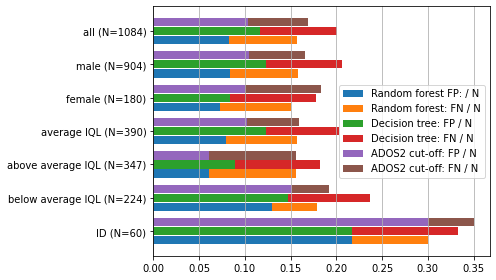

In [21]:
labels = ['{} (N={})'.format(i, int(rf_results.loc[i]['N'])) for i in rf_results.index]
fig, ax = plt.subplots(figsize=(7, 4))

y_pos = np.arange(len(rf_results))
dy = .27
ax.barh(y_pos+.27, rf_results['fp/all'], label='Random forest FP: / N', height=.25)
ax.barh(y_pos+.27, rf_results['fn/all'], left=rf_results['fp/all'], label='Random forest: FN / N', height=.25)
ax.barh(y_pos, dt_results['fp/all'], label='Decision tree: FP / N', height=.25)
ax.barh(y_pos, dt_results['fn/all'], left=dt_results['fp/all'], label='Decision tree: FN / N', height=.25)
ax.barh(y_pos-.27, baseline['fp/all'], label='ADOS2 cut-off: FP / N', height=.25)
ax.barh(y_pos-.27, baseline['fn/all'], left=baseline['fp/all'], label='ADOS2 cut-off: FN / N', height=.25)

ax.legend()
ax.grid(True, axis='x')
ax.set_yticks(y_pos)
ax.invert_yaxis()
ax.set_yticklabels(labels)

fig.tight_layout()
fig.savefig('compare_error_rate_abs.jpg', dpi=300)

In [22]:
# Bootstrap RF and ADOS2

n_iterations = 200
n_sample_size = 900

from sklearn.utils import resample
import sys
dfp_stat = {}
dfn_stat = {}
derr_stat = {}

rf_bs_results = []
ados2_results = []


for bs_iter in range(n_iterations):
    sys.stdout.write(f'\r{bs_iter}/{n_iterations}...')
    x_train, y_train = resample(x, y, replace=True, stratify=y, n_samples=n_sample_size, random_state=bs_iter)
    x_test, y_test = [], []
    for idx, p in x.iterrows():
        if idx not in x_train.index:
            y_test.append(y.loc[idx])
            x_test.append(x.loc[idx])
    x_test = pd.concat(x_test, axis=1).T
    y_test = pd.Series(y_test, index=x_test.index)
    
    rf =  ensemble.RandomForestClassifier(**gs_rf.best_params_, random_state=bs_iter).fit(x_train, y_train)
    y_rf = rf.predict(x_test)
    
    rf_bs_results.append(get_results(y_test, y_rf, x_test))
    _, ados2 = ados2_cutoff_results(x_test, y_test)
    ados2_results.append(ados2)
    

    dfp_stat[bs_iter] = rf_bs_results[-1]['fp/all'] - ados2['fp/all']
    dfn_stat[bs_iter] = rf_bs_results[-1]['fn/all'] - ados2['fn/all']
    derr_stat[bs_iter] = rf_bs_results[-1]['error'] - ados2['error']

sys.stdout.write(f'\r{n_iterations}/{n_iterations}...')
print('\ndone')

200/200...
done


In [23]:
# based on distributions obtained by bootstrap:
# paired t-test for significance of differences in accuracies and false negatives:
# *error between normal IQL and low IQL
# *fn between normal IQL and high IQL
# *error between normal IQL and ID

for name, r in [('ados2', ados2_results), ('rf', rf_bs_results)]:
    errors = pd.DataFrame([a['error'] for a in r], index=np.arange(len(ados2_results)))
    fn = pd.DataFrame([a['fn/all'] for a in r], index=np.arange(len(ados2_results)))
    print(f'===== {name} =====')
    tests = {'normal vs low': dict(a=errors['average IQL'], b=errors['below average IQL'], alternative='less'),
             'male vs female': dict(a=errors['male'], b=errors['female'], alternative='less'),
             'all vs average': dict(a=errors['all'], b=errors['average IQL'], alternative='two-sided'),
             'average vs ID': dict(a=errors['average IQL'], b=errors['ID'], alternative='two-sided'),
             'average vs high': dict(a=errors['average IQL'], b=errors['above average IQL'], alternative='two-sided'),
             'average vs high (fn)': dict(a=fn['average IQL'], b=fn['above average IQL'], alternative='less'),
            }
    
    for n, t in tests.items():
        print(n)
        print(stats.ttest_rel(**t))

===== ados2 =====
normal vs low
Ttest_relResult(statistic=-12.881244123995442, pvalue=2.6060221776300425e-28)
male vs female
Ttest_relResult(statistic=-6.018523345803158, pvalue=4.166208521707506e-09)
all vs average
Ttest_relResult(statistic=8.645120665152067, pvalue=1.7754594367256038e-15)
average vs ID
Ttest_relResult(statistic=-33.130012166006374, pvalue=6.302559021481588e-83)
average vs high
Ttest_relResult(statistic=1.626214135732608, pvalue=0.10548661017396707)
average vs high (fn)
Ttest_relResult(statistic=-21.8425169334384, pvalue=4.740457815518277e-55)
===== rf =====
normal vs low
Ttest_relResult(statistic=-10.312841444051271, pvalue=1.4922129902618182e-20)
male vs female
Ttest_relResult(statistic=-0.36224718282802465, pvalue=0.35877586065675154)
all vs average
Ttest_relResult(statistic=0.3055543467146326, pvalue=0.7602633677220288)
average vs ID
Ttest_relResult(statistic=-20.65674546716936, pvalue=2.145151457741162e-51)
average vs high
Ttest_relResult(statistic=3.890738540472

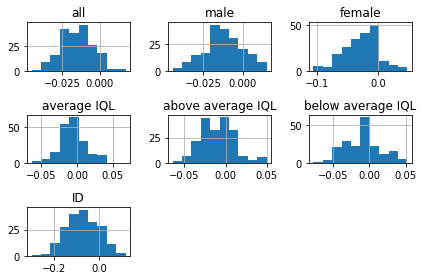

In [24]:
# plot distributions differences in errors for sub-cohorts: error_rf - error_ados2
derr = pd.DataFrame(derr_stat).T
derr.hist()
plt.tight_layout()

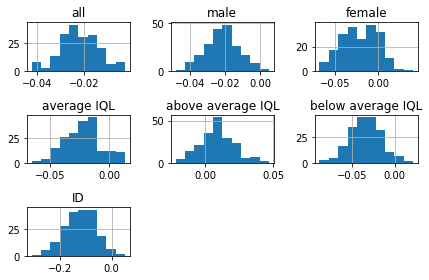

In [25]:
# plot distributions differences in false positives for sub-cohorts: fp_rf - fp_ados2
dfp = pd.DataFrame(dfp_stat).T
dfp.hist()
plt.tight_layout()

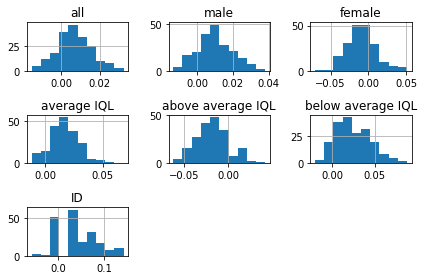

In [26]:
# plot distributions differences in false negatives for sub-cohorts: fn_rf - fn_ados2
dfn = pd.DataFrame(dfn_stat).T
dfn.hist()
plt.tight_layout()

In [27]:
# print confidence of the increase/decrease of various metrics,
# estimated through the distributions obtained by bootstrapping
print('==== Accuracy ====')
for subcohort in derr:
    print('{}: confidence in decrease of error rate: p={}'.format(subcohort, np.sum(derr[subcohort] >= 0) / len(derr)))

print('\n\n==== False Positivies / N ====')
for subcohort in dfp:
    print('{}: confidence in decrease of FP: p={}'.format(subcohort, np.sum(dfp[subcohort] >= 0) / len(dfp)))

print('\n\n==== False Negatives / N ====')
for subcohort in dfn:
    print('{}: confidence in increase of FNR: p={}'.format(subcohort, np.sum(dfn[subcohort] <= 0) / len(dfn)))

==== Accuracy ====
all: confidence in decrease of error rate: p=0.11
male: confidence in decrease of error rate: p=0.18
female: confidence in decrease of error rate: p=0.245
average IQL: confidence in decrease of error rate: p=0.415
above average IQL: confidence in decrease of error rate: p=0.315
below average IQL: confidence in decrease of error rate: p=0.425
ID: confidence in decrease of error rate: p=0.21


==== False Positivies / N ====
all: confidence in decrease of FP: p=0.0
male: confidence in decrease of FP: p=0.01
female: confidence in decrease of FP: p=0.23
average IQL: confidence in decrease of FP: p=0.115
above average IQL: confidence in decrease of FP: p=0.795
below average IQL: confidence in decrease of FP: p=0.045
ID: confidence in decrease of FP: p=0.04


==== False Negatives / N ====
all: confidence in increase of FNR: p=0.29
male: confidence in increase of FNR: p=0.205
female: confidence in increase of FNR: p=0.755
average IQL: confidence in increase of FNR: p=0.135
a

In [28]:
# Identification of relevant features: Train classifiers on the whole data

# For displaying the decision tree, nodes that do not change the classification result are pruned
# credits: https://stackoverflow.com/questions/51397109/prune-unnecessary-leaves-in-sklearn-decisiontreeclassifier

from sklearn.tree._tree import TREE_LEAF

def is_leaf(inner_tree, index):
    # Check whether node is leaf node
    return (inner_tree.children_left[index] == TREE_LEAF and 
            inner_tree.children_right[index] == TREE_LEAF)

def prune_index(inner_tree, decisions, index=0):
    # Start pruning from the bottom - if we start from the top, we might miss
    # nodes that become leaves during pruning.
    # Do not use this directly - use prune_duplicate_leaves instead.
    if not is_leaf(inner_tree, inner_tree.children_left[index]):
        prune_index(inner_tree, decisions, inner_tree.children_left[index])
    if not is_leaf(inner_tree, inner_tree.children_right[index]):
        prune_index(inner_tree, decisions, inner_tree.children_right[index])

    # Prune children if both children are leaves now and make the same decision:     
    if (is_leaf(inner_tree, inner_tree.children_left[index]) and
        is_leaf(inner_tree, inner_tree.children_right[index]) and
        (decisions[index] == decisions[inner_tree.children_left[index]]) and 
        (decisions[index] == decisions[inner_tree.children_right[index]])):
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
        ##print("Pruned {}".format(index))

def prune_duplicate_leaves(mdl):
    # Remove leaves if both decisions result in the same class
    decisions = mdl.tree_.value.argmax(axis=2).flatten().tolist() # Decision for each node
    prune_index(mdl.tree_, decisions)

In [29]:
# ---- fit tree ----
tree_all = gs_tree.best_estimator_.fit(x, y)
# print score
print(tree_all.score(x, y))

0.8468634686346863


In [30]:
# ---- make tree a little prettier and render it ----
prune_duplicate_leaves(tree_all)
dot_data = tree.export_graphviz(tree_all, out_file=None, feature_names=x.columns, 
                                class_names=['not ASD','ASD'], filled=True, impurity=False, 
                                proportion=False)

# change absolute samples to relatives
import re
pattern1 = re.compile('value = \[[0-9]+, [0-9]+\]')
pattern2 = re.compile('[0-9]+')

def convert_to_relative(s):
    numbers = np.array(re.findall(pattern2, s[0]), dtype=int)
    return '{:.1f} % ASD'.format(numbers[1]/numbers.sum()*100)


dot_data2 = re.sub(pattern1, convert_to_relative, dot_data)

# render and save tree
graph = graphviz.Source(dot_data2)
graph.render("tree_all")
tree_all.score(x, y)

0.8468634686346863

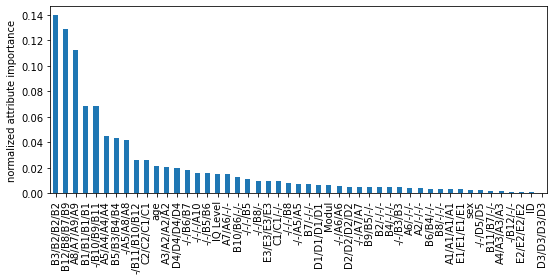

In [31]:
# Random Forest: Train and plot impurity-based feature importances

rf_all = gs_rf.best_estimator_.fit(x, y)
rf_all.score(x, y)
fig, ax = plt.subplots(figsize=(7.8, 4))
ax.set_ylabel('normalized attribute importance')
pd.Series(rf_all.feature_importances_, index=x.columns).sort_values(ascending=False).plot.bar()
fig.tight_layout()
fig.savefig('rf_feature_importance.jpg', dpi=300)